Python-AWIPS Tutorial Notebook

---

# Objectives

* Use python-awips to connect to an edex server
* Create a plot for a regional area of the United States (Florida)
* Define and filter data request for METAR and Synoptic surface obs
* Use the maps database to request and draw state boundaries (no use of Cartopy.Feature in this example)
* Stylize and plot surface data using Metpy

---

## Table of Contents

[1 Imports](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#imports)<br>  
[2 Function: get_cloud_cover()](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#function-get-cloud-cover)<br>  
[3 Function: make_map()](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#function-make-map)<br>  
[4 Function: extract_plotting_data()](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#function-extract-plotting-data)<br>  
[5 Function: plot_data()](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#function-plot-data)<br>  
[6 Initial Setup](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#initial-setup)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.1 Initial EDEX Connection](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#initial-edex-connection)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.2 Maps Request and Response](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#maps-request-and-response)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.3 Define Geographic Filter](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#define-geographic-filter)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.4 Define Time Filter](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#define-time-filter)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.5 Define Common Parameters for Data Requests](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#define-common-parameters-for-data-requests)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.6 Define METAR Request](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#define-metar-request)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[6.7 Define Synoptic Request](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#define-synoptic-request)<br>  
[7 Get the Data!](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#get-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Get the EDEX Responses](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#get-the-edex-responses)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.2 Extract Plotting Data](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#extract-plotting-data)<br>  
[8 Plot the Data](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#plot-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.1 Draw the Region](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#draw-the-region)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.2 Plot METAR Data](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#plot-metar-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.3 Plot Synoptic Data](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#plot-synoptic-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[8.4 Plot both METAR and Synoptic Data](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#plot-both-metar-and-synoptic-data)<br>  
[9 See Also](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#see-also)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[9.1 Related Notebooks](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#related-notebooks)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[9.2 Additional Documentation](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html#additional-documentation)<br>  

## Imports

The imports below are used throughout the notebook.  Note the first two imports are coming directly from python-awips and allow us to connect to an EDEX server, and define a timrange used for filtering the data.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from metpy.units import units
from metpy.calc import wind_components
from metpy.plots import simple_layout, StationPlot, StationPlotLayout, sky_cover
import warnings

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Function: get_cloud_cover()

Returns the cloud coverage values as integer codes (0 through 8).

In [2]:
def get_cloud_cover(code):
    if 'OVC' in code:
        return 8
    elif 'BKN' in code:
        return 6
    elif 'SCT' in code:
        return 4
    elif 'FEW' in code:
        return 2
    else:
        return 0

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Function: make_map()

In order to plot more than one image, it's easiest to define common logic in a function.  Here, a new function called **make_map** is defined.  This function uses the [matplotlib.pyplot package (plt)](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html) to create a figure and axis.  The geographic extent is set and lat/lon gridlines are added for context.

In [3]:
def make_map(bbox, proj=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16,12),subplot_kw=dict(projection=proj))
    ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True, color='#e7e7e7')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Function: extract_plotting_data()

Grab the simple variables out of the response data we have (attaching correct units), and
put them into a dictionary that we will hand the plotting function later:

- Get wind components from speed and direction
- Convert cloud coverage values to integer codes [0 - 8]
- Assign temperature, dewpoint, and sea level pressure the the correct units
- Account for missing values (by using `nan`)

In [4]:
def extract_plotting_data(arr, datatype):
    """
    Extract all necessary data for plotting for either
    datatype: 'obs' or 'sfcobs'
    """
    
    data = dict()
    data['latitude']  = np.array(arr['latitude'])
    data['longitude'] = np.array(arr['longitude'])
    tmp = np.array(arr['temperature'], dtype=float)
    dpt = np.array(arr['dewpoint'], dtype=float)
    direction = np.array(arr['windDir'])

    # Suppress nan masking warnings
    warnings.filterwarnings("ignore",category =RuntimeWarning)
    
    # Account for missing values
    tmp[tmp == -9999.0] = 'nan'
    dpt[dpt == -9999.] = 'nan'
    direction[direction == -9999.0] = 'nan'
    
    data['air_pressure_at_sea_level'] = np.array(arr['seaLevelPress'])* units('mbar')
    u, v = wind_components(np.array(arr['windSpeed']) * units('knots'),
                               direction * units.degree)
    
    data['eastward_wind'], data['northward_wind'] = u, v
    data['present_weather'] = arr['presWeather']

    
    # metars uses 'stationName' for its identifier and temps are in deg C
    # metars also has sky coverage
    if datatype == "obs":
        data['stid'] = np.array(arr['stationName'])
        data['air_temperature'] = tmp * units.degC
        data['dew_point_temperature'] = dpt * units.degC
        data['cloud_coverage'] = [int(get_cloud_cover(x)) for x in arr['skyCover']]
        
    # synoptic obs uses 'stationId', and temps are in Kelvin
    elif datatype == "sfcobs":
        data['stid'] = np.array(arr['stationId'])
        data['air_temperature'] = tmp * units.kelvin
        data['dew_point_temperature'] = dpt * units.kelvin
    
    return data

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Function: plot_data()

This function makes use of Metpy.StationPlotLayout and Metpy.StationPlot to add all surface observation data to our plot.  The logic is very similar for both METAR and Synoptic data, so a `datatype` argument is used to distinguish between which data is being drawn, and then draws the appropriate features.

This function plots:
- Wind barbs
- Air temperature
- Dew point temperature
- Precipitation
- Cloud coverage (for METARS)

In [5]:
def plot_data(data, title, axes, datatype):
    custom_layout = StationPlotLayout()
    custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
    custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degF', color='darkred')
    custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degF', color='darkgreen')
    custom_layout.add_value('E', 'precipitation', fmt='0.1f', units='inch', color='blue')
    # metars has sky coverage
    if datatype == 'obs':
        custom_layout.add_symbol('C', 'cloud_coverage', sky_cover)
    axes.set_title(title)
    stationplot = StationPlot(axes, data['longitude'], data['latitude'], clip_on=True,
                              transform=ccrs.PlateCarree(), fontsize=10)
    custom_layout.plot(stationplot, data)

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Initial Setup

Connect to an EDEX server and define several [new data request objects](http://unidata.github.io/python-awips/api/IDataRequest.html).

In this example we're using multiple different datatypes from EDEX, so we'll create a request object for each of the following:
- [The states outlines (datatype **maps**)](#Define-Maps-Request)
- [The METAR data (datatype **obs**)](#Define-METAR-Request)
- [The Synoptic data (datatype **sfc**)](#Define-Synoptic-Request)

Some of the request use filters, so we'll also create several filters than can be used for the various data requests as well.

### Initial EDEX Connection

First we establish a connection to Unidata's public EDEX server.

In [6]:
# EDEX connection
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)

### Maps Request and Response
The maps data request will give us data to draw our state outlines of interest (Florida and its neighboring states).  We will retrieve the data response object here so we can create a geographic filter for the METAR and Synoptic data requests.

In [7]:
# Define the maps request
maps_request = DataAccessLayer.newDataRequest('maps')
# filter for multiple states
maps_request.addIdentifier('table', 'mapdata.states')
maps_request.addIdentifier('geomField', 'the_geom')
maps_request.addIdentifier('inLocation', 'true')
maps_request.addIdentifier('locationField', 'state')
maps_request.setParameters('state','name','lat','lon')
maps_request.setLocationNames('FL','GA','MS','AL','SC','LA')
maps_response = DataAccessLayer.getGeometryData(maps_request)
print("Found " + str(len(maps_response)) + " MultiPolygons")

Found 6 MultiPolygons


### Define Geographic Filter

The previous EDEX request limited the data by using a **parameter** for the maps database called **state**.  We can take the results from that filter and get a geographic **envelope** based on the Florida polygon that was returned from the previous cell.

> **Warning**: Without such a filter you may be requesting many tens of thousands of records.

In [8]:
# Append each geometry to a numpy array
states = np.array([])
for ob in maps_response:
    print(ob.getString('name'), ob.getString('state'), ob.getNumber('lat'), ob.getNumber('lon'))
    states = np.append(states,ob.getGeometry())
    # if this is Florida grab geographic info
    if ob.getString('name') == "Florida":
        bounds = ob.getGeometry().bounds
        fl_lat = ob.getNumber('lat')
        fl_lon = ob.getNumber('lon')

if bounds is None:
    print("Error, no record found for Florida!")

else:    
    # buffer our bounds by +/i degrees lat/lon
    bbox=[bounds[0]-3,bounds[2]+3,bounds[1]-1.5,bounds[3]+1.5]

    # Create envelope geometry
    envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                        (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                        (bbox[0],bbox[2])])
    
print(envelope)

Florida FL 28.67402 -82.50934
Georgia GA 32.65155 -83.44848
Louisiana LA 31.0891 -92.02905
Alabama AL 32.79354 -86.82676
Mississippi MS 32.75201 -89.66553
South Carolina SC 33.93574 -80.89899
POLYGON ((-90.63429260299995 23.02105161600002, -90.63429260299995 32.50101280200016, -77.03199876199994 32.50101280200016, -77.03199876199994 23.02105161600002, -90.63429260299995 23.02105161600002))


### Define Time Filter

Both the METAR and Synoptic datasets should be filtered by time to avoid requesting an unreasonable amount of data.  By defining one filter now, we can use it in both of their data requests to EDEX.

> **Note**: Here we will use the most recent hour as our default filter.  Try adjusting the timerange and see the difference in the final plots.

In [9]:
# Filter for the last hour
lastHourDateTime = datetime.utcnow() - timedelta(minutes = 60)
start = lastHourDateTime.strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

beginRange = datetime.strptime( start , "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( end , "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

print(timerange)

(Nov 11 22 19:00:54 , Nov 11 22 20:00:54 )


### Define Common Parameters for Data Requests

METAR obs and Synoptic obs share several of the same parameters.  By defining them here, they can be reused for both of the requests and this makes our code more efficient.

In [10]:
shared_params = ["timeObs", "longitude", "latitude", "temperature",
                 "dewpoint", "windDir", "windSpeed", "seaLevelPress",
                 "presWeather", "skyLayerBase"]
print(shared_params)

['timeObs', 'longitude', 'latitude', 'temperature', 'dewpoint', 'windDir', 'windSpeed', 'seaLevelPress', 'presWeather', 'skyLayerBase']


### Define METAR Request

To get METAR data we must use the **obs** datatype.  To help limit the amount of data returned, we will narrow the request by using a geographic **envelope**, setting the request **parameters**, and using **timerange** as a time filter.

In [11]:
# New metar request
metar_request = DataAccessLayer.newDataRequest("obs", envelope=envelope)

# metar specifc parameters
metar_params = ["stationName", "skyCover"]
# combine all parameters
all_metar_params = shared_params + metar_params
# set the parameters on the metar request
metar_request.setParameters(*(all_metar_params))

print(metar_request)

DefaultDataRequest(datatype=obs, identifiers={}, parameters=['timeObs', 'longitude', 'latitude', 'temperature', 'dewpoint', 'windDir', 'windSpeed', 'seaLevelPress', 'presWeather', 'skyLayerBase', 'stationName', 'skyCover'], levels=[], locationNames=[], envelope=<dynamicserialize.dstypes.com.vividsolutions.jts.geom.Envelope.Envelope object at 0x13abe40a0>)


### Define Synoptic Request

Similar to the request above, we will limit the amount of data returned by using a geographic **envelope**, setting the request **parameters**, and using **timerange** as a time filter.

However, in order to access synoptic observations we will use the **sfcobs** datatype.

In [12]:
# New sfcobs/SYNOP request
syn_request = DataAccessLayer.newDataRequest("sfcobs", envelope=envelope)

# (sfcobs) uses stationId, while (obs) uses stationName
syn_params = ["stationId"]
# combine all parameters
all_syn_params = shared_params + syn_params
# set the parameters on the synoptic request
syn_request.setParameters(*(all_syn_params))

print(syn_request)

DefaultDataRequest(datatype=sfcobs, identifiers={}, parameters=['timeObs', 'longitude', 'latitude', 'temperature', 'dewpoint', 'windDir', 'windSpeed', 'seaLevelPress', 'presWeather', 'skyLayerBase', 'stationId'], levels=[], locationNames=[], envelope=<dynamicserialize.dstypes.com.vividsolutions.jts.geom.Envelope.Envelope object at 0x105048bb0>)


[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Get the Data!

We have already obtained our maps data, but we still have to collect our observation data.

### Get the EDEX Responses

In [13]:
# METARs data
metar_response = DataAccessLayer.getGeometryData(metar_request,timerange)
# function getMetarObs was added in python-awips 18.1.4
metars = DataAccessLayer.getMetarObs(metar_response)
print("Found " + str(len(metar_response)) + " METAR records")
print("\tUsing " + str(len(metars['temperature'])) + " temperature records")

# Synoptic data
syn_response = DataAccessLayer.getGeometryData(syn_request,timerange)
# function getSynopticObs was added in python-awips 18.1.4
synoptic = DataAccessLayer.getSynopticObs(syn_response)
print("Found " + str(len(syn_response)) + " Synoptic records")
print("\tUsing " + str(len(synoptic['temperature'])) + " temperature records")

Found 4116 METAR records
	Using 179 temperature records
Found 259 Synoptic records
	Using 63 temperature records


### Extract Plotting Data

In [14]:
# Pull all necessary plotting information for the metar data
metars_data = extract_plotting_data(metars, 'obs')
print(str(len(metars_data['stid'])) + " METARs stations")

# Pull all necessary plotting information for the synoptic data
synoptic_data = extract_plotting_data(synoptic, 'sfcobs')
print(str(len(synoptic_data['stid'])) + " Synoptic stations")

179 METARs stations
63 Synoptic stations


[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## Plot the Data


### Draw the Region

Here we will draw our region by using the **states** polygons we retreived from EDEX [earlier in this example](#Maps-Request-and-Response).  To create this plot we use the [make_map()](#Function:-make_map()) function which also adds lines of latitude and longitude for additional context.

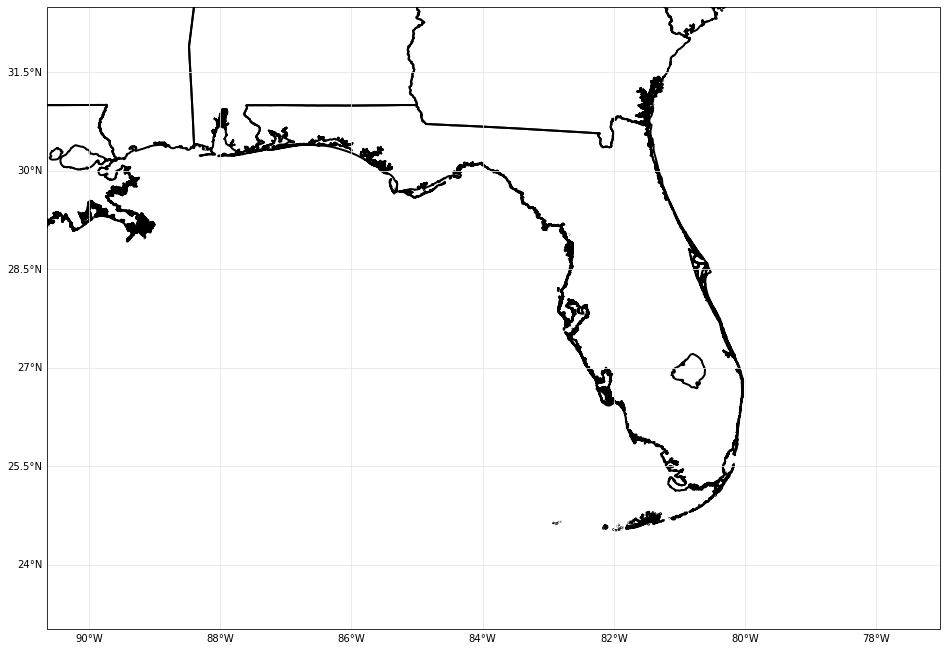

In [15]:
# Create the figure and axes used for the plot
fig, ax = make_map(bbox=bbox)
# Create a feature based off our states polygons
shape_feature = ShapelyFeature(states,ccrs.PlateCarree(), 
                    facecolor='none', linestyle="-",edgecolor='#000000',linewidth=2)
ax.add_feature(shape_feature)

### Plot METAR Data

On the same axes (**ax**) and figure (**fig**) plot the METAR data.

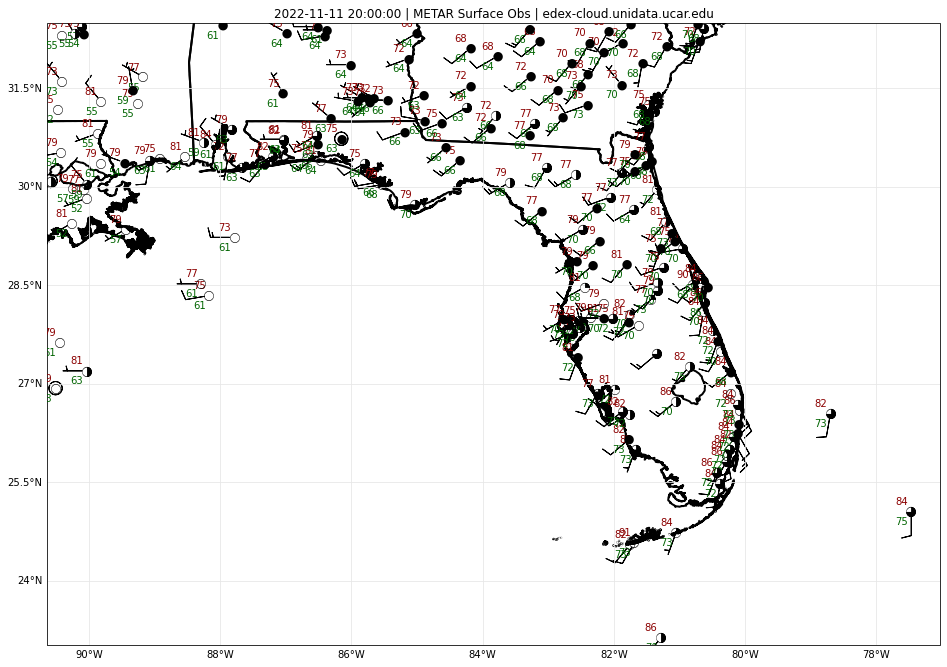

In [16]:
# Create a title for the plot
title = str(metar_response[-1].getDataTime()) + " | METAR Surface Obs | " + edexServer
# Plot the station information for METARs data
plot_data(metars_data, title, ax, 'obs')
# Display the figure
fig

### Plot Synoptic Data

On a new axes and figure (**ax_syn**, **fig_syn**) plot the map and synoptic data.

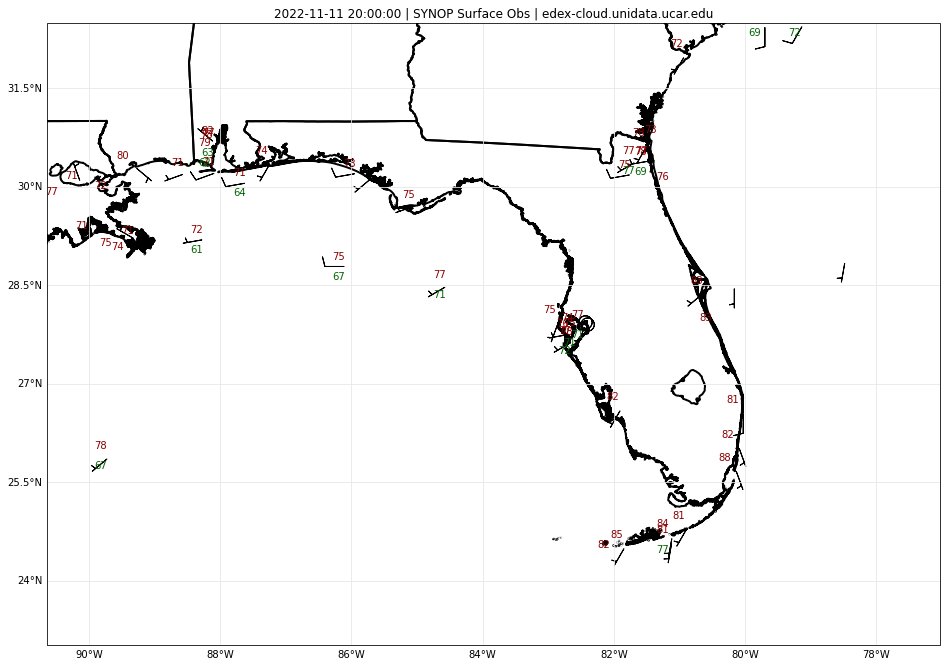

In [17]:
# Create a new figure and axes for the synoptic data
fig_syn, ax_syn = make_map(bbox=bbox)
# Create the states feature from the polygons
shape_feature = ShapelyFeature(states,ccrs.PlateCarree(), 
                    facecolor='none', linestyle="-",edgecolor='#000000',linewidth=2)
ax_syn.add_feature(shape_feature)
# Create a title for the figure
title = str(syn_response[-1].getDataTime()) + " | SYNOP Surface Obs | " + edexServer
# Draw the synoptic data
plot_data(synoptic_data, title, ax_syn, 'sfcobs')

### Plot both METAR and Synoptic Data

Add the synoptic data to our first axes and figure (**ax**, **fig**) that already contains our map and METARs data.

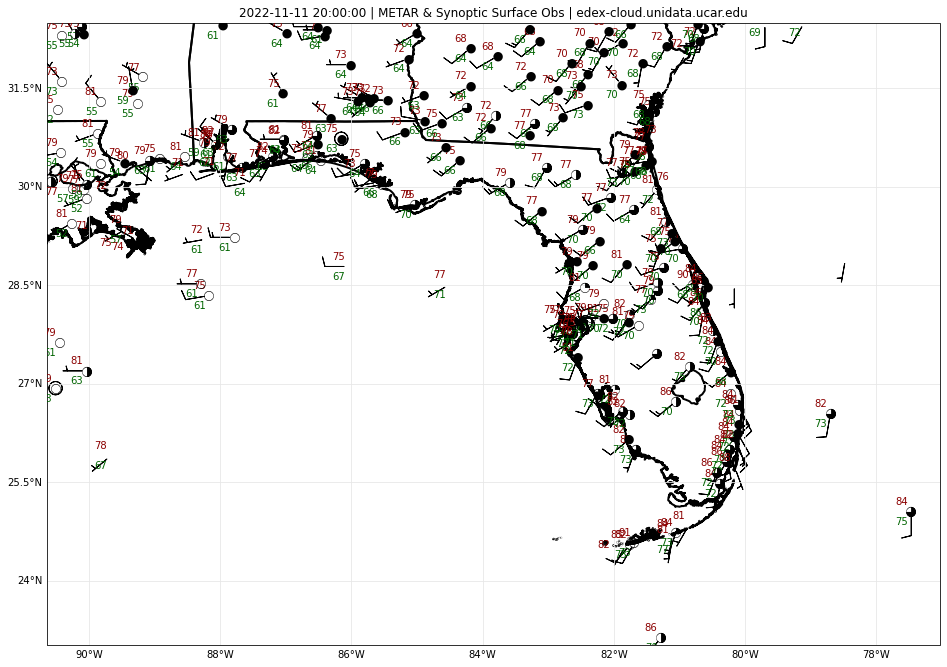

In [18]:
# Create a title for both the METAR and Synopotic data
title = str(syn_response[-1].getDataTime()) + " | METAR & Synoptic Surface Obs | " + edexServer
# Draw the synoptic on the first axes that already has the metar data
plot_data(synoptic_data, title, ax, 'sfcobs')
# Display the figure
fig

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---

## See Also

- [Aviation Weather Center Static METAR Plots Information](https://www.aviationweather.gov/metar/help?page=plot)

### Related Notebooks

- [Metar Station Plot with MetPy](http://unidata.github.io/python-awips/examples/generated/METAR_Station_Plot_with_MetPy.html)
- [Map Resources and Topography](http://unidata.github.io/python-awips/examples/generated/Map_Resources_and_Topography.html)

### Additional Documentation

**python-awips:**

- [DataAccessLayer.changeEDEXHost()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.changeEDEXHost)
- [DataAccessLayer.newDataRequest()](http://unidata.github.io/python-awips/api/DataAccessLayer.html#awips.dataaccess.DataAccessLayer.newDataRequest)
- [IDataRequest](http://unidata.github.io/python-awips/api/IDataRequest.html)
- [DataAccessLayer.getGeometryData](http://unidata.github.io/python-awips/api/PyGeometryData.html)

**datetime:**

- [datetime.datetime](https://docs.python.org/3/library/datetime.html#datetime-objects)
- [datetime.utcnow()](https://docs.python.org/3/library/datetime.html?#datetime.datetime.utcnow)
- [datetime.timedelta](https://docs.python.org/3/library/datetime.html#timedelta-objects)
- [datetime.strftime() and datetime.strptime()](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)

**numpy:**

- [np.array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)

**cartopy:**

- [cartopy projection list](https://scitools.org.uk/cartopy/docs/v0.14/crs/projections.html?#cartopy-projection-list)

**matplotlib:**

- [matplotlib.pyplot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
- [matplotlib.pyplot.figure()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html)
- [ax.set_extent](https://matplotlib.org/stable/api/image_api.html?highlight=set_extent#matplotlib.image.AxesImage.set_extent)
- [ax.set_title](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_title.html)


**metpy:**

- [metpy.calc.wind_components](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_components.html)
- [metpy.plots.StationPlot()](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlot.html)
- [metpy.plots.StationPlotLayout()](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.StationPlotLayout.html)
- [metpy.units](https://unidata.github.io/MetPy/latest/api/generated/metpy.units.html)

[Top](https://unidata.github.io/python-awips/examples/generated/Regional_Surface_Obs_Plot.html)

---